The goal of this notebook is to figure out what fraction of Avana guides have a SNV in the targeting sequence in at least one cell line. And then we want to calculate 

Specifically, I want to create a matrix similar to the one that I created in "New_Which_Ancestry_Genes_Have_SNP_In_Guide"

In [15]:
#Set up the environment
library(tidyverse)
library(reshape2)
library(janitor)
library(taigr)

#Define functions
show_msg <- function(x){ 
    print(x)
    flush.console()
}

Loading required package: RCurl


Attaching package: ‘RCurl’


The following object is masked from ‘package:tidyr’:

    complete


Loading required package: httr



In [16]:
#Load in the avana bed file
setwd("/home/jupyter/Ancestry/filtered_output/avana14")
avana.bed <- read.table('Avana14_filtering.bed', sep = "\t", header = F) %>%
rename("chr" = 1, "start" = 2, "end" = 3, "sgrna" = 4) 
head(avana.bed)
nrow(avana.bed)

,chr,start,end,sgrna
,<chr>,<int>,<dbl>,<chr>
1,chr1,69527,69550,TCTCCATTCGGTGAGCCAGT
2,chr1,168646,168669,TGTAGTCCCAGCTACTCAGG
3,chr1,383420,383443,GAGAATCTCTTGAACCCGGG
4,chr1,424270,424293,TGTAATCCCAGTACTTTGGG
5,chr1,451271,451294,ATAATGGTCAGATAGTGGAG
6,chr1,451344,451367,TCTCCACACCACCAACGACG


[1] 73597

One problem with this bed file is that the "start" position is always the lower number, and it is not listed as relative to where the PAM is.

We need to adjust the bed file to flip the positions.

In [3]:
#First, load in the guide map so that we can figure out which guides are on the plus or minus strand
setwd("/home/jupyter/Ancestry/gwas")
guide.map = read.table("internal-21q4_v9-achilles-guide-map.csv", header = T, sep = ",") %>%
select(sgrna, genome_alignment) %>%
mutate(genome_alignment = gsub("..*_", "", genome_alignment)) %>%
rename("strand" = genome_alignment) %>%
distinct(sgrna, .keep_all = TRUE)
head(guide.map)

#Load in the Avana bed file to get positions for the ancestry-associated guides
#Also add the annotation information from guides.to.keep to the avana.bed matrix
#Also flip the start and end positions if the sgrna is on the minus strand
setwd("/home/jupyter/Ancestry/filtered_output/avana14")
avana.bed <- read.table('Avana14_filtering.bed', sep = "\t", header = F) %>%
rename("chr" = 1, "start" = 2, "end" = 3, "sgrna" = 4) %>%
inner_join(guide.map, by = "sgrna") %>%
mutate("true_start" = ifelse(strand %in% "+", start, end)) %>%
mutate("true_end" = ifelse(strand %in% "+", end, start))%>% #This line and the line above will create two new columns to flip the start and end if the sgrna is on the minus strand
select(chr, true_start, true_end, sgrna) %>%
rename("start" = true_start) %>%
rename("end" = true_end)

tail(avana.bed)
dim(avana.bed)

,sgrna,strand
,<chr>,<chr>
1,AAAAAAATCCAGCAATGCAG,+
2,AAAAAACCCGTAGATAGCCT,+
3,AAAAAAGAAGAAAAAACCAG,-
4,AAAAAAGCTCAAGAAGGAGG,-
5,AAAAAAGGCTGTAAAAGCGT,+
6,AAAAAAGGGCTCCAAAAAGG,+


,chr,start,end,sgrna
,<chr>,<dbl>,<dbl>,<chr>
72099,chrX,155514278,155514256,TTCCCCTTAAAAGGGCCAGA
72100,chrX,155773991,155773969,GGAGAGGGCCTGTTTACAGG
72101,chrX,155774016,155773994,GGGTTTGCACAATAAGGGAA
72102,chrX,155774310,155774288,AGATGAAGAGGTGCTCACTA
72103,chrX,156001472,156001450,AGCCACAGCATGAAACACCG
72104,chrX,156003813,156003791,GCTCCCTCCCAGACATGCAG


[1] 72104     4

In [4]:
#Filter the ccle variant calls so that it only includes SNPs that map to at least one sgRNA targeting sequence
#Now use bcftools to subset the big ccle snp matrix to only include SNPs in that range
system(glue::glue("
cd /home/jupyter/Ancestry/rfmix
/home/jupyter/Ancestry/software/bcftools/bcftools view -R /home/jupyter/Ancestry/filtered_output/avana14/Avana14_filtering.bed split.all_chroms.maf.subset.reheader.vcf.gz -o /home/jupyter/Ancestry/analysis/map_ccle_snps_to_avana_guides/snps.in.all.avana.guides.vcf.gz -Oz
"))

Now let's map all of the CCLE variants to the avana guides. 

First, filter the variant calls so that it only includes SNVs which map to Avana guides.
Next, figure out where in those guides the SNPs map to (recycle code from the "New_Which_Ancestry_Genes_Have_SNP_In_Guide" notebook.

In [4]:
#First, load in the ccle variants and format the dataset so that it looks nice
setwd("/home/jupyter/Ancestry/analysis/map_ccle_snps_to_avana_guides")
ccle.variant.calls = read.table("snps.in.all.avana.guides.vcf.gz", sep = "\t") %>%
filter(V7 %in% "PASS") %>%
select(-V1, -V2, -V4, -V5, -V6, -V7, -V8, -V9)

#Reformat the genotyping data
ccle.variant.calls[2:ncol(ccle.variant.calls)] = apply(ccle.variant.calls[2:ncol(ccle.variant.calls)], 2, function(x){gsub(":..*", "", x) })
ccle.variant.calls[2:ncol(ccle.variant.calls)] = apply(ccle.variant.calls[2:ncol(ccle.variant.calls)], 2, function(x){gsub("0\\|0", 0, x) })
ccle.variant.calls[2:ncol(ccle.variant.calls)] = apply(ccle.variant.calls[2:ncol(ccle.variant.calls)], 2, function(x){gsub("0\\|1", 1, x) })
ccle.variant.calls[2:ncol(ccle.variant.calls)] = apply(ccle.variant.calls[2:ncol(ccle.variant.calls)], 2, function(x){gsub("1\\|0", 1, x) })
ccle.variant.calls[2:ncol(ccle.variant.calls)] = apply(ccle.variant.calls[2:ncol(ccle.variant.calls)], 2, function(x){gsub("1\\|1", 2, x) })

#Fix the SNP column
ccle.variant.calls = ccle.variant.calls %>%
separate(V3, sep = ":", into = c("chr", "pos", "ref", "alt"))

head(ccle.variant.calls)
dim(ccle.variant.calls)


#Then fix the names on that dataset
#First extract the sample names from the vcf file, then load them into R
system(glue::glue("
cd /home/jupyter/Ancestry/analysis/map_ccle_snps_to_avana_guides
/home/jupyter/Ancestry/software/bcftools/bcftools query -l /home/jupyter/Ancestry/analysis/map_ccle_snps_to_avana_guides/snps.in.ancestry.guides.vcf.gz > ccle.sample.names.txt
"))

setwd("/home/jupyter/Ancestry/analysis/map_ccle_snps_to_avana_guides")
sample.names = read.table("ccle.sample.names.txt", sep = "\t") %>%
pull(1)
head(sample.names)


ccle.variant.calls = ccle.variant.calls
colnames(ccle.variant.calls) = c("chr", "pos", "ref", "alt", sample.names)
head(ccle.variant.calls)

,chr,pos,ref,alt,V10,V11,V12,V13,V14,V15,⋯,V994,V995,V996,V997,V998,V999,V1000,V1001,V1002,V1003
,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,⋯,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
1,chr1,1407014,G,A,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
2,chr1,1471992,T,C,2,2,1,0,1,0,⋯,1,2,2,2,0,1,1,1,0,0
3,chr1,1918305,G,A,1,0,0,0,0,0,⋯,0,0,0,0,0,0,0,1,1,1
4,chr1,2028260,G,A,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
5,chr1,2351722,A,G,2,0,1,1,0,0,⋯,0,1,0,2,0,0,0,0,1,0
6,chr1,2408761,T,C,1,2,2,2,2,2,⋯,2,2,2,2,1,1,0,2,1,2


[1] 3432  998

[1] "ACH-000657" "ACH-000617" "ACH-000685" "ACH-000632" "ACH-000171"
[6] "ACH-000863"

,chr,pos,ref,alt,ACH-000657,ACH-000617,ACH-000685,ACH-000632,ACH-000171,ACH-000863,⋯,ACH-000981,ACH-000217,ACH-000116,ACH-000930,ACH-000986,ACH-000342,ACH-001130,ACH-000287,ACH-000798,ACH-000645
,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,⋯,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
1,chr1,1407014,G,A,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
2,chr1,1471992,T,C,2,2,1,0,1,0,⋯,1,2,2,2,0,1,1,1,0,0
3,chr1,1918305,G,A,1,0,0,0,0,0,⋯,0,0,0,0,0,0,0,1,1,1
4,chr1,2028260,G,A,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
5,chr1,2351722,A,G,2,0,1,1,0,0,⋯,0,1,0,2,0,0,0,0,1,0
6,chr1,2408761,T,C,1,2,2,2,2,2,⋯,2,2,2,2,1,1,0,2,1,2


In [ ]:
#For each guide in avana.bed calculate if there is a snp in the guide, then calculate the position of that SNP
snp.in.guide.list = NULL
for(i in 1:nrow(avana.bed)){
  
    #get information for the guide of interest
    guide.start = avana.bed$start[i] %>% as.numeric() #get the position of the guide
    guide.chrom = avana.bed$chr[i] #get the chromosome that the guide is on
    sgrna.barcode = avana.bed$sgrna[i] #get the barcode sequence
    
    #subset out subset.ccle.snps so that it only includes snps on that chromsome
    subset.to.chr = ccle.variant.calls %>% filter(chr %in% guide.chrom)
    
    #now calculate the differential and add it to the list outside of the loop
    snp.position = guide.start - as.numeric(subset.to.chr$pos)
    snp.in.guide.list[[i]] = snp.position
}
names(snp.in.guide.list) = avana.bed$sgrna #Then name the list with the corresponding sgrna sequence

In [ ]:
#Assign the SNP ID as names for each vector

annotated.snp.in.guide.list = NULL
for(i in 1:length(snp.in.guide.list)){
        
    chromosome = avana.bed$chr[i] #get the chromosome which that guide targets
    
    #Now get a vector of snp positions and annotate the relative snp position vector with that information
    vector.to.annotate = snp.in.guide.list[[i]] #grab the vector that we need to annotate in this loop
    snp.vector = ccle.variant.calls %>% filter(chr %in% chromosome) %>% mutate(snp = paste(chr, ":", pos, ":", ref, ":", alt, sep = "")) %>% pull(snp) #make a vector that contains the snp information
    names(vector.to.annotate) = snp.vector #now apply that annotation to the vector of snp positions
    
    #Report the information outside of the loop
    annotated.snp.in.guide.list[[i]] = vector.to.annotate
    
}

names(annotated.snp.in.guide.list) = avana.bed$sgrna #Then name the list with the corresponding sgrna sequence

In [ ]:
#Go through the list and remove the SNPs that don't map to a sgrna
pruned.snp.list = annotated.snp.in.guide.list %>%
lapply(function(x){
    vector = abs(x)
    val.to.return = vector[vector %in% 0:22]
    return(val.to.return)
}) %>% compact(1) #compact is part of the purrr package and will remove guides that don't have a SNP

head(pruned.snp.list)
length(pruned.snp.list)

In [ ]:
#Now let's go through and create a nice data frame from this list.

snp.in.guide.df = NULL
for(i in 1:length(pruned.snp.list)){
    
   sgrna = pruned.snp.list[[i]] #this is a vector (normally length = 1, sometimes more with all of the snps that map to a vector)
   
    #If there is only one snp that maps to that sgrna, simply construct the vector and add it to the data frame
    #If there is more than one snp, then we need to get a little more fancy and construct a data frame first
    if(length(sgrna) == 1){
        sgrna = names(pruned.snp.list[i]) #get the sgrna for this iteration of the loop
        snp = names(pruned.snp.list[[i]]) #get the snp code for this iteration of the loop
        position = pruned.snp.list[[i]] #Get the relative position of the SNP on the guide for this iteration of the loop
        vector.to.add = c(sgrna, snp, position) #Make a vector of values to add to the data frame
        snp.in.guide.df = rbind(snp.in.guide.df, vector.to.add) %>% data.frame() %>% #Then add that vector to the data frame
        rename("sgrna" = 1, "snp" = 2, "position" = 3)  
    } else {
        sgrna = names(pruned.snp.list[i]) #get the sgrna for this iteration of the loop
        sgrna.vector = rep(sgrna, length(pruned.snp.list[[i]])) #get a vector that contains the sgrna now, length = #snps
        snp.vector = names(pruned.snp.list[[i]]) #get the snp code for this iteration of the loop
        position.vector = pruned.snp.list[[i]] #Get the relative position of the SNP on the guide for this iteration of the loop
        df.to.add = cbind(sgrna.vector, snp.vector, position.vector) %>% data.frame() %>%
        rename("sgrna" = 1, "snp" = 2, "position" = 3) #bind it all into a data frame
        snp.in.guide.df = rbind(snp.in.guide.df, df.to.add) %>% data.frame() %>%
        rename("sgrna" = 1, "snp" = 2, "position" = 3)
 }
}

row.names(snp.in.guide.df) = NULL #remove the row names on the new df since they are useless
head(snp.in.guide.df)
dim(snp.in.guide.df)

Yay we finally have a nice data frame constructed. Now we need to calculate p-values for the association between the SNP and the sgrna score.

In [ ]:
#Load in the guide-level data
setwd("/home/jupyter/Ancestry/gwas")
replicate.map = read.table("internal-21q4_v9-achilles-replicate-map.csv", header = T, sep = ",")
guide.map = read.table("internal-21q4_v9-achilles-guide-map.csv", header = T, sep = ",")
logfc = read.table("internal-21q4_v9-achilles-logfold-change.csv", header = T, sep = ",", check.names = FALSE)

In [ ]:
#Get a list of guides that we want to keep
guides.to.keep = snp.in.guide.df %>%
pull(sgrna)


#First, subset the logfc data so that it only includes the guides we are interested in.
#Then collapse and average by sample
guide.level.data = logfc %>%
rename("sgrna" = 1) %>%
filter(sgrna %in% all_of(guides.to.keep)) %>%
t() %>%
row_to_names(1, remove_rows_above = FALSE) %>%
data.frame() %>%
rownames_to_column("sample") %>%
mutate(sample = plyr::mapvalues(sample, from = replicate.map$replicate_ID, to = replicate.map$DepMap_ID, warn_missing = FALSE)) %>%
melt(id = "sample") %>%
mutate(value = as.numeric(value))%>%
group_by(sample, variable) %>%
summarise(mean(value)) %>%
dcast(sample ~ variable)

In [ ]:
#Process ccle.variant.calls so that it is ready for doing our analysis.
ccle.variant.calls.for.analysis = ccle.variant.calls %>%
mutate(snp = paste(chr, ":", pos, ":", ref, ":", alt, sep =""), .before = chr) %>%
select(-chr, -pos, -ref, -alt)

head(ccle.variant.calls.for.analysis)

In [ ]:
#Now loop through all of the variants in 'snp.in.guide.df' and calculate whether that SNP is associated with the guide 

pval.output = NULL
for(i in 1:nrow(snp.in.guide.df)){
  
    
    sgrna.of.interest = snp.in.guide.df$sgrna[i] #get the sgrna we are interested in
    snp.of.interest = snp.in.guide.df$snp[i] #get the snp we are interested in
    
    #First get two vectors of cell line IDs with or without the SNP
    lines.with.snp = ccle.variant.calls.for.analysis %>%
    filter(snp %in% snp.of.interest) %>%
    select(-snp) %>%
    apply(2, as.numeric) %>%
    .[. > 0] %>%
    names(.)

    lines.without.snp = setdiff(colnames(ccle.variant.calls.for.analysis[2:ncol(ccle.variant.calls.for.analysis)]), lines.with.snp)

    
    #Get vectors of values for the sgrna scores for cell lines with or without the snp
    with.snp.scores = guide.level.data %>%
    select(sample, all_of(sgrna.of.interest)) %>%
    rename("sgrna" = 2) %>%
    filter(sample %in% lines.with.snp) %>%
    pull(sgrna) %>%
    as.numeric(.)
    
    without.snp.scores = guide.level.data %>%
    select(sample, all_of(sgrna.of.interest)) %>%
    rename("sgrna" = 2) %>%
    filter(sample %in% lines.without.snp) %>%
    pull(sgrna) %>%
    as.numeric(.)
    
    
    #Perform a t-test
    
    if(length(with.snp.scores) >= 10 && length(without.snp.scores) >= 10){
    pval = t.test(with.snp.scores, without.snp.scores, alternative = "two.sided")$p.value } else {
    pval = 1
    }
    
    
    #return the data to the object outside of the loop
    pval.output = c(pval.output, pval)
}

In [ ]:
#bind the p-values back into the main data frame and calculate fdr
final.df = snp.in.guide.df %>%
mutate(pval = pval.output) %>%
mutate("fdr" = p.adjust(pval.output, method = "BH", n = length(pval.output))) %>%
mutate(position = factor(position, levels = 0:22)) %>%
rename("pval" = 4, "fdr" = 5) 

head(final.df)

In [ ]:
#Write this file so that we don't need to do all kinds of re-calculations again
setwd("/home/jupyter/Ancestry/analysis/snv_position_single_guide")
write.table(final.df, "snv_position_single_guide_finaldf.txt", sep = "\t", col.names = TRUE, row.names = FALSE, quote = FALSE)

In [3]:
#Read the file back in
setwd("/home/jupyter/Ancestry/analysis/snv_position_single_guide")
final.df = read.table("snv_position_single_guide_finaldf.txt", sep = "\t", header = T) %>%
mutate(position = factor(position, levels = 0:22))

head(final.df)

,sgrna,snp,position,pval,fdr
,<chr>,<chr>,<fct>,<dbl>,<dbl>
1,GGGATGACTGCCACGTCGCA,chr1:1918305:G:A,15,1.424607e-09,9.813687e-09
2,CACCAGCTACCGCTTCACCA,chr1:2028260:G:A,12,1.000000e+00,1.000000e+00
3,TGAACTCATCACAATCACAG,chr1:2351722:A:G,15,7.068879e-06,3.214676e-05
4,GCAGTGTCACCAGCACGCCA,chr1:2408761:T:C,5,1.933726e-03,5.956056e-03
5,GCAGTGTCACCAGCACGCCA,chr1:2408773:G:A,17,3.226362e-05,1.318846e-04
6,GCTCAGGGACCACAGTCCCG,chr1:2645520:C:T,18,7.691961e-01,9.311692e-01


# Add the Doench data to the plot

John doench did some caluclations in his nature biotech paper that will tell us the expected impact of a mismatch at each site. Let's do some calculations with these data and then add it to the data frame.

In [4]:
#Load in the John Doench data
setwd("/home/jupyter/Ancestry/analysis/snv_position_single_guide")
doench.data = read.table("Doench_Data.txt", sep = "\t", header = T)
head(doench.data)

,Mismatch.Type,Position,t.test.p.value,Negative.log.p.value.,Mean.Delta.LFC,Percent.Active,Total.number.of.guides
,<chr>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<int>
1,rA:dG,1,0.150804067,0.8215869,0.5710550,0.8571429,14
2,rA:dG,2,0.082562533,1.0832170,0.8698198,0.7857143,14
3,rA:dG,3,0.000488654,3.3109984,2.8684061,0.4285714,14
4,rA:dG,4,0.000052900,4.2767312,2.7673637,0.3529412,17
5,rA:dG,5,0.004209299,2.3757902,2.0295610,0.5000000,14
6,rA:dG,6,0.000081900,4.0867880,2.4402229,0.4545455,22


In [5]:
#Calculate the median pval at each site
doench.median.pvals = doench.data %>%
group_by(Position) %>%
summarise(median(t.test.p.value)) %>%
data.frame() %>%
rename("position" = 1, "median_pval" = 2) %>%
mutate(index = seq(from = 0, to = 19, by = 1))

doench.median.pvals

str(doench.median.pvals)

position,median_pval,index
<int>,<dbl>,<dbl>
1,0.149619709,0
2,0.086452126,1
3,0.008456349,2
4,0.006320862,3
5,0.004322493,4
6,0.018654097,5
7,0.011965942,6
8,0.024517843,7
9,0.006454412,8


'data.frame':	20 obs. of  3 variables:
 $ position   : int  1 2 3 4 5 6 7 8 9 10 ...
 $ median_pval: num  0.14962 0.08645 0.00846 0.00632 0.00432 ...
 $ index      : num  0 1 2 3 4 5 6 7 8 9 ...


Warning message:
“Removed 262 rows containing non-finite values (`stat_boxplot()`).”
Warning message:
“Removed 262 rows containing non-finite values (`stat_boxplot()`).”


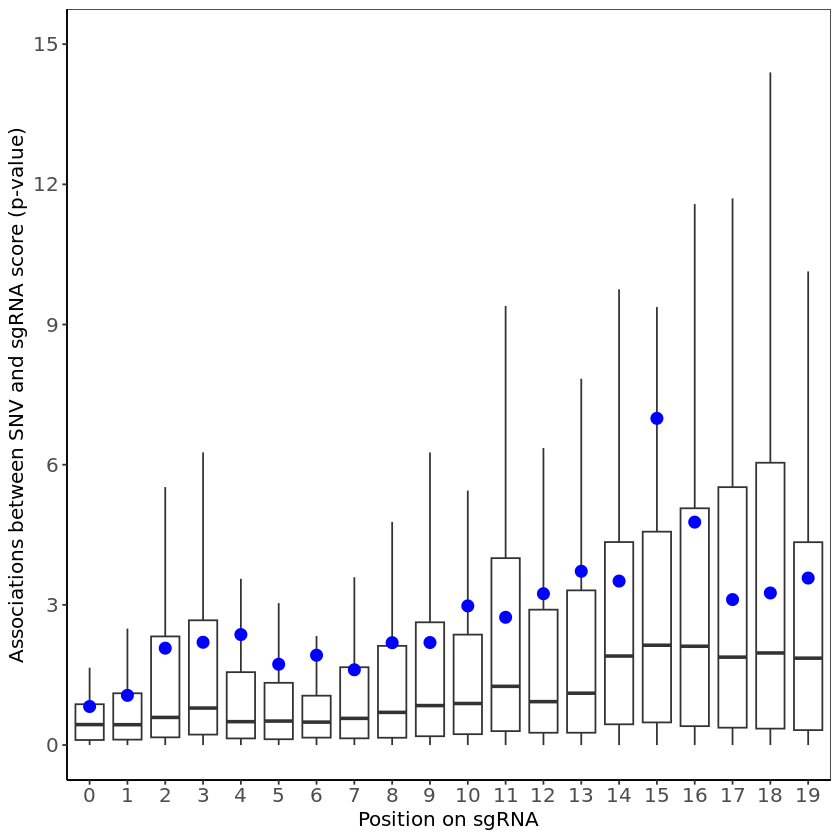

In [6]:
#Now plot the plot
final.df %>%
filter(position %in% c(0:19)) %>%
ggplot() +
geom_boxplot(outlier.shape = NA, aes(x = position, y = -log10(pval))) +
geom_point(data = doench.median.pvals, shape = 19, size = 3, color = "blue", aes(x = position, y = -log10(median_pval))) +
theme_bw() +

theme(
panel.grid.major = element_blank(),
panel.grid.minor = element_blank(), 
axis.line = element_line(color = "black")
) +

theme(
axis.title.x = element_text(size = 12),
axis.title.y = element_text(size = 12,)
) +

theme(
axis.text=element_text(size = 12),
axis.title=element_text(size = 12)
) +

theme(
legend.title = element_text(size = 12),
legend.text = element_text(size = 12)
) +

scale_y_continuous(breaks = seq(0, 15, by = 3), limits = c(0,15)) +

ylab("Associations between SNV and sgRNA score (p-value)") +
xlab("Position on sgRNA")


#Export it to the google bucket
setwd('/home/jupyter/Ancestry/figures')
ggsave("guide_significance_by_position.pdf", width = 3.5, height = 2)
system(glue::glue("
cd /home/jupyter/Ancestry/figures
gsutil cp guide_significance_by_position.pdf gs://fc-45c0e148-0b1c-4244-9bfc-feb559bbc514
"))

In [7]:
#Calculate the number of guides where there is a significant association between a SNV and that guide
number.with.snp = final.df %>%
filter(fdr < 0.05) %>%
pull(sgrna) %>%
unique() %>%
length()

number.with.snp

num.unique.snippy.guides = final.df$sgrna %>% unique() %>% length()

fraction.of.all.guides = number.with.snp/nrow(avana.bed)
fraction.of.snippy.guides = number.with.snp/num.unique.snippy.guides


fraction.of.all.guides
fraction.of.snippy.guides



[1] 1542

[1] 0.02095194

[1] 0.4120791

Calculate the correlation between the Doench data and our depmap data

In [8]:
#First, collapse the final.df data so that it is in the same format as the doench.median.pvals dataset
final.df.medians = final.df %>%
select(position, pval) %>%
group_by(position) %>%
summarise(median(pval))%>%
rename("median_pval" = 2) %>%
mutate(position = as.numeric(position))

final.doench.medians = doench.median.pvals %>%
select(-position) %>%
rename("doench_median_pval" = median_pval, "position" = index)


#Merge the two datasets together
ours.doench.merged = inner_join(final.df.medians, final.doench.medians, by = "position")


head(ours.doench.merged)

cor.test(ours.doench.merged$median_pval, ours.doench.merged$doench_median_pval)

position,median_pval,doench_median_pval
<dbl>,<dbl>,<dbl>
1,0.3343614,0.086452126
2,0.3505110,0.008456349
3,0.2386018,0.006320862
4,0.1423374,0.004322493
5,0.3143139,0.018654097
6,0.2595093,0.011965942



	Pearson's product-moment correlation

data:  ours.doench.merged$median_pval and ours.doench.merged$doench_median_pval
t = 3.0905, df = 17, p-value = 0.006639
alternative hypothesis: true correlation is not equal to 0
95 percent confidence interval:
 0.2000624 0.8283261
sample estimates:
      cor 
0.5997704 


`geom_smooth()` using formula = 'y ~ x'
`geom_smooth()` using formula = 'y ~ x'


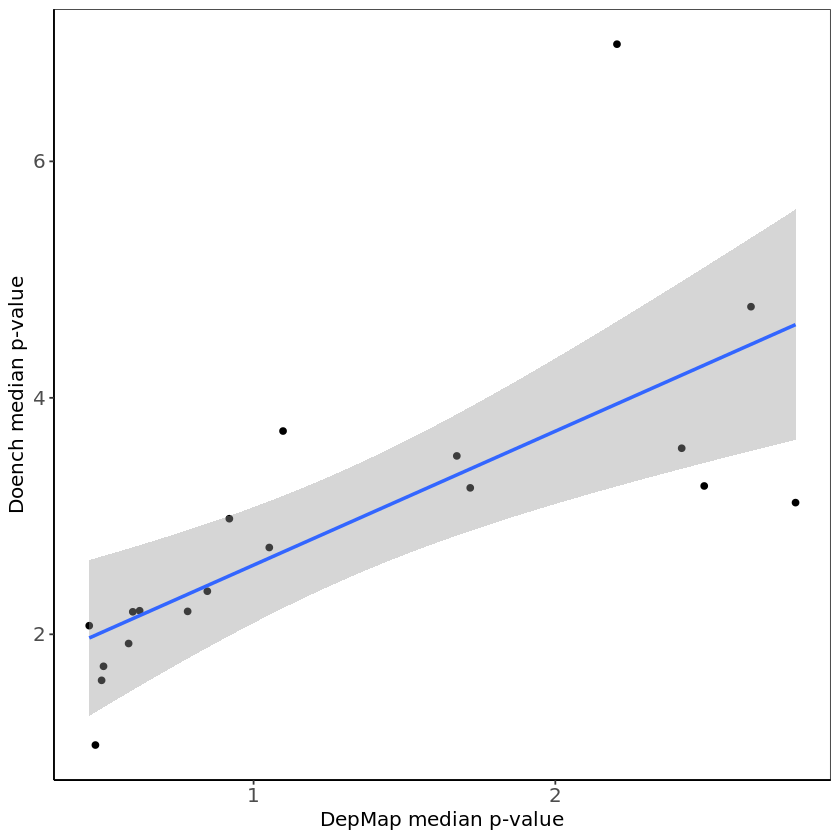

In [13]:
#Generate a correlation plot
ours.doench.merged %>%
ggplot(aes(x = -log10(median_pval), y = -log10(doench_median_pval))) +
geom_point() +
geom_smooth(method=lm) +
theme_bw() +

theme(
panel.grid.major = element_blank(),
panel.grid.minor = element_blank(), 
axis.line = element_line(color = "black")
) +

theme(
axis.title.x = element_text(size = 12),
axis.title.y = element_text(size = 12)
) +

theme(
axis.text=element_text(size = 12),
axis.title=element_text(size = 12)
) +

theme(
legend.title = element_text(size = 12),
legend.text = element_text(size = 12)
) +

xlab("DepMap median p-value") +
ylab("Doench median p-value") 


#Export it to the google bucket
setwd("/home/jupyter/Ancestry/analysis/snv_position_single_guide")
ggsave("doench_ours_scatterplot.pdf", width = 4, height = 4)
system(glue::glue("
cd /home/jupyter/Ancestry/analysis/snv_position_single_guide
gsutil cp doench_ours_scatterplot.pdf gs://fc-45c0e148-0b1c-4244-9bfc-feb559bbc514
"))


# Create a plot that shows the magnitude of the difference

We can probably just ressurect the old volcano plot that I made before.

This is kind of a mess since I am adding the magnitude data after the fact, but whatever.

In [10]:
#Read the file back in
setwd("/home/jupyter/Ancestry/analysis/snv_position_single_guide")
final.df = read.table("snv_position_single_guide_finaldf.txt", sep = "\t", header = T) %>%
mutate(position = factor(position, levels = 0:22))

head(final.df)

,sgrna,snp,position,pval,fdr
,<chr>,<chr>,<fct>,<dbl>,<dbl>
1,GGGATGACTGCCACGTCGCA,chr1:1918305:G:A,15,1.424607e-09,9.813687e-09
2,CACCAGCTACCGCTTCACCA,chr1:2028260:G:A,12,1.000000e+00,1.000000e+00
3,TGAACTCATCACAATCACAG,chr1:2351722:A:G,15,7.068879e-06,3.214676e-05
4,GCAGTGTCACCAGCACGCCA,chr1:2408761:T:C,5,1.933726e-03,5.956056e-03
5,GCAGTGTCACCAGCACGCCA,chr1:2408773:G:A,17,3.226362e-05,1.318846e-04
6,GCTCAGGGACCACAGTCCCG,chr1:2645520:C:T,18,7.691961e-01,9.311692e-01


In [29]:
#Load in the guide -> gene map and convert final.df so that it also has the gene symbol
guide.map = load.from.taiga(data.name='public-22q1-305b', data.version=24, data.file='Achilles_guide_map') %>%
mutate(gene = word(gene, 1))

#Add the gene column to final.df
final.df.gene = final.df %>%
mutate("gene" = plyr::mapvalues(from = guide.map$sgrna, to = guide.map$gene, sgrna, warn_missing = FALSE))

Fetching https://cds.team/taiga/api/dataset/public-22q1-305b/24 
Status 200 


No encoding supplied: defaulting to UTF-8.



loading cached data version from  /home/jupyter/.taiga/public-22q1-305b_24.toc 


Loading from cached file /home/jupyter/.taiga/90832e86cae84f918423ad1d83fa4222_achilles-guide-map.rds



,sgrna,snp,position,pval,fdr,gene
,<chr>,<chr>,<fct>,<dbl>,<dbl>,<chr>
1,GGGATGACTGCCACGTCGCA,chr1:1918305:G:A,15,1.424607e-09,9.813687e-09,TMEM52
2,CACCAGCTACCGCTTCACCA,chr1:2028260:G:A,12,1.000000e+00,1.000000e+00,GABRD
3,TGAACTCATCACAATCACAG,chr1:2351722:A:G,15,7.068879e-06,3.214676e-05,SNRPN
4,GCAGTGTCACCAGCACGCCA,chr1:2408761:T:C,5,1.933726e-03,5.956056e-03,PEX10
5,GCAGTGTCACCAGCACGCCA,chr1:2408773:G:A,17,3.226362e-05,1.318846e-04,PEX10
6,GCTCAGGGACCACAGTCCCG,chr1:2645520:C:T,18,7.691961e-01,9.311692e-01,TTC34


In [11]:
#Load in the genotyping data
#First, load in the ccle variants and format the dataset so that it looks nice
setwd("/home/jupyter/Ancestry/analysis/map_ccle_snps_to_avana_guides")
ccle.variant.calls = read.table("snps.in.all.avana.guides.vcf.gz", sep = "\t") %>%
filter(V7 %in% "PASS") %>%
select(-V1, -V2, -V4, -V5, -V6, -V7, -V8, -V9)

#Reformat the genotyping data
ccle.variant.calls[2:ncol(ccle.variant.calls)] = apply(ccle.variant.calls[2:ncol(ccle.variant.calls)], 2, function(x){gsub(":..*", "", x) })
ccle.variant.calls[2:ncol(ccle.variant.calls)] = apply(ccle.variant.calls[2:ncol(ccle.variant.calls)], 2, function(x){gsub("0\\|0", 0, x) })
ccle.variant.calls[2:ncol(ccle.variant.calls)] = apply(ccle.variant.calls[2:ncol(ccle.variant.calls)], 2, function(x){gsub("0\\|1", 1, x) })
ccle.variant.calls[2:ncol(ccle.variant.calls)] = apply(ccle.variant.calls[2:ncol(ccle.variant.calls)], 2, function(x){gsub("1\\|0", 1, x) })
ccle.variant.calls[2:ncol(ccle.variant.calls)] = apply(ccle.variant.calls[2:ncol(ccle.variant.calls)], 2, function(x){gsub("1\\|1", 2, x) })


#Then fix the names on that dataset
#First extract the sample names from the vcf file, then load them into R
system(glue::glue("
cd /home/jupyter/Ancestry/analysis/map_ccle_snps_to_avana_guides
/home/jupyter/Ancestry/software/bcftools/bcftools query -l /home/jupyter/Ancestry/analysis/map_ccle_snps_to_avana_guides/snps.in.ancestry.guides.vcf.gz > ccle.sample.names.txt
"))

setwd("/home/jupyter/Ancestry/analysis/map_ccle_snps_to_avana_guides")
sample.names = read.table("ccle.sample.names.txt", sep = "\t") %>%
pull(1)

ccle.variant.calls = ccle.variant.calls
colnames(ccle.variant.calls) = c("snp", sample.names)

melted.ccle.variant.calls = ccle.variant.calls %>%
melt(id = "snp")

head(melted.ccle.variant.calls)

,snp,variable,value
,<chr>,<fct>,<chr>
1,chr1:1407014:G:A,ACH-000657,0
2,chr1:1471992:T:C,ACH-000657,2
3,chr1:1918305:G:A,ACH-000657,1
4,chr1:2028260:G:A,ACH-000657,0
5,chr1:2351722:A:G,ACH-000657,2
6,chr1:2408761:T:C,ACH-000657,1


In [32]:
#Load in the 22q1 chronos scores
chronos.22q1 = load.from.taiga(data.name='public-22q1-305b', data.version=24, data.file='CRISPR_gene_effect') %>%
data.frame(check.names = FALSE) %>%
rownames_to_column("sample")

#Get a vector of 22q1 samples
chronos.samples = chronos.22q1 %>% pull(sample)

#Melt the chronos scores
melted.chronos.22q1 = chronos.22q1 %>%
melt(id = "sample") %>%
rename("gene" = variable) %>%
mutate(gene = word(gene, 1))

melted.chronos.22q1 %>% head()

Fetching https://cds.team/taiga/api/dataset/public-22q1-305b/24 
Status 200 


No encoding supplied: defaulting to UTF-8.



loading cached data version from  /home/jupyter/.taiga/public-22q1-305b_24.toc 


Loading from cached file /home/jupyter/.taiga/90832e86cae84f918423ad1d83fa4222_crispr-gene-effect.rds



,sample,gene,value
,<chr>,<chr>,<dbl>
1,ACH-000001,A1BG,-0.13022665
2,ACH-000004,A1BG,0.08567935
3,ACH-000005,A1BG,-0.09358537
4,ACH-000007,A1BG,-0.03090007
5,ACH-000009,A1BG,-0.02383669
6,ACH-000011,A1BG,0.08655529


In [36]:
#Filter the ccle variant calls so that it only includes samples with chronos scores
chronos.only.melted.ccle.variant.calls = melted.ccle.variant.calls %>%
filter(variable %in% all_of(chronos.samples)) %>%
mutate(value = as.numeric(value))

In [41]:
#Loop through all of the guides in final.df and calculate the absolute difference in dependency score
differential.vector = NULL
for(i in 1:nrow(final.df.gene)){
    
    #print the loop status
    show_msg(i)
    
    #Get some variables from final.df and store them so the code is easier to read
    guide.of.interest = final.df.gene[i, 1]
    snp.of.interest = final.df.gene[i, 2]
    gene.of.interest = final.df.gene[i, 6]
    
    
    #Get two vectors of samples with and without the guide
    samples.with.variant = chronos.only.melted.ccle.variant.calls %>%
    filter(snp %in% all_of(snp.of.interest)) %>%
    filter(value >= 1) %>%
    pull(variable)
    
    samples.without.variant = chronos.only.melted.ccle.variant.calls %>%
    filter(snp %in% all_of(snp.of.interest)) %>%
    filter(value == 0) %>%
    pull(variable)
    
    
    #Get two vectors of chronos scores for samples with and without the snp
    chronos.with.variant = melted.chronos.22q1 %>%
    filter(gene %in% all_of(gene.of.interest)) %>%
    filter(sample %in% all_of(samples.with.variant)) %>%
    pull(value)
    
    chronos.without.variant = melted.chronos.22q1 %>%
    filter(gene %in% all_of(gene.of.interest)) %>%
    filter(sample %in% all_of(samples.without.variant)) %>%
    pull(value)
    
    
    #Calculate the mean of each of the vectors
    chronos.with.variant.mean = chronos.with.variant %>% mean()
    chronos.without.variant.mean = chronos.without.variant %>% mean()
    
    
    #Calculate the differential
    chronos.differential = chronos.with.variant.mean - chronos.without.variant.mean
    
    
    #Write the differential to the vector outside of the loop
    differential.vector = c(differential.vector, chronos.differential)
    
}

[1] 1
[1] 2
[1] 3
[1] 4
[1] 5
[1] 6
[1] 7
[1] 8
[1] 9
[1] 10
[1] 11
[1] 12
[1] 13
[1] 14
[1] 15
[1] 16
[1] 17
[1] 18
[1] 19
[1] 20
[1] 21
[1] 22
[1] 23
[1] 24
[1] 25
[1] 26
[1] 27
[1] 28
[1] 29
[1] 30
[1] 31
[1] 32
[1] 33
[1] 34
[1] 35
[1] 36
[1] 37
[1] 38
[1] 39
[1] 40
[1] 41
[1] 42
[1] 43
[1] 44
[1] 45
[1] 46
[1] 47
[1] 48
[1] 49
[1] 50
[1] 51
[1] 52
[1] 53
[1] 54
[1] 55
[1] 56
[1] 57
[1] 58
[1] 59
[1] 60
[1] 61
[1] 62
[1] 63
[1] 64
[1] 65
[1] 66
[1] 67
[1] 68
[1] 69
[1] 70
[1] 71
[1] 72
[1] 73
[1] 74
[1] 75
[1] 76
[1] 77
[1] 78
[1] 79
[1] 80
[1] 81
[1] 82
[1] 83
[1] 84
[1] 85
[1] 86
[1] 87
[1] 88
[1] 89
[1] 90
[1] 91
[1] 92
[1] 93
[1] 94
[1] 95
[1] 96
[1] 97
[1] 98
[1] 99
[1] 100
[1] 101
[1] 102
[1] 103
[1] 104
[1] 105
[1] 106
[1] 107
[1] 108
[1] 109
[1] 110
[1] 111
[1] 112
[1] 113
[1] 114
[1] 115
[1] 116
[1] 117
[1] 118
[1] 119
[1] 120
[1] 121
[1] 122
[1] 123
[1] 124
[1] 125
[1] 126
[1] 127
[1] 128
[1] 129
[1] 130
[1] 131
[1] 132
[1] 133
[1] 134
[1] 135
[1] 136
[1] 137
[1] 138
[1] 

[1] 1035
[1] 1036
[1] 1037
[1] 1038
[1] 1039
[1] 1040
[1] 1041
[1] 1042
[1] 1043
[1] 1044
[1] 1045
[1] 1046
[1] 1047
[1] 1048
[1] 1049
[1] 1050
[1] 1051
[1] 1052
[1] 1053
[1] 1054
[1] 1055
[1] 1056
[1] 1057
[1] 1058
[1] 1059
[1] 1060
[1] 1061
[1] 1062
[1] 1063
[1] 1064
[1] 1065
[1] 1066
[1] 1067
[1] 1068
[1] 1069
[1] 1070
[1] 1071
[1] 1072
[1] 1073
[1] 1074
[1] 1075
[1] 1076
[1] 1077
[1] 1078
[1] 1079
[1] 1080
[1] 1081
[1] 1082
[1] 1083
[1] 1084
[1] 1085
[1] 1086
[1] 1087
[1] 1088
[1] 1089
[1] 1090
[1] 1091
[1] 1092
[1] 1093
[1] 1094
[1] 1095
[1] 1096
[1] 1097
[1] 1098
[1] 1099
[1] 1100
[1] 1101
[1] 1102
[1] 1103
[1] 1104
[1] 1105
[1] 1106
[1] 1107
[1] 1108
[1] 1109
[1] 1110
[1] 1111
[1] 1112
[1] 1113
[1] 1114
[1] 1115
[1] 1116
[1] 1117
[1] 1118
[1] 1119
[1] 1120
[1] 1121
[1] 1122
[1] 1123
[1] 1124
[1] 1125
[1] 1126
[1] 1127
[1] 1128
[1] 1129
[1] 1130
[1] 1131
[1] 1132
[1] 1133
[1] 1134
[1] 1135
[1] 1136
[1] 1137
[1] 1138
[1] 1139
[1] 1140
[1] 1141
[1] 1142
[1] 1143
[1] 1144
[1] 1145
[

[1] 1946
[1] 1947
[1] 1948
[1] 1949
[1] 1950
[1] 1951
[1] 1952
[1] 1953
[1] 1954
[1] 1955
[1] 1956
[1] 1957
[1] 1958
[1] 1959
[1] 1960
[1] 1961
[1] 1962
[1] 1963
[1] 1964
[1] 1965
[1] 1966
[1] 1967
[1] 1968
[1] 1969
[1] 1970
[1] 1971
[1] 1972
[1] 1973
[1] 1974
[1] 1975
[1] 1976
[1] 1977
[1] 1978
[1] 1979
[1] 1980
[1] 1981
[1] 1982
[1] 1983
[1] 1984
[1] 1985
[1] 1986
[1] 1987
[1] 1988
[1] 1989
[1] 1990
[1] 1991
[1] 1992
[1] 1993
[1] 1994
[1] 1995
[1] 1996
[1] 1997
[1] 1998
[1] 1999
[1] 2000
[1] 2001
[1] 2002
[1] 2003
[1] 2004
[1] 2005
[1] 2006
[1] 2007
[1] 2008
[1] 2009
[1] 2010
[1] 2011
[1] 2012
[1] 2013
[1] 2014
[1] 2015
[1] 2016
[1] 2017
[1] 2018
[1] 2019
[1] 2020
[1] 2021
[1] 2022
[1] 2023
[1] 2024
[1] 2025
[1] 2026
[1] 2027
[1] 2028
[1] 2029
[1] 2030
[1] 2031
[1] 2032
[1] 2033
[1] 2034
[1] 2035
[1] 2036
[1] 2037
[1] 2038
[1] 2039
[1] 2040
[1] 2041
[1] 2042
[1] 2043
[1] 2044
[1] 2045
[1] 2046
[1] 2047
[1] 2048
[1] 2049
[1] 2050
[1] 2051
[1] 2052
[1] 2053
[1] 2054
[1] 2055
[1] 2056
[

[1] 2857
[1] 2858
[1] 2859
[1] 2860
[1] 2861
[1] 2862
[1] 2863
[1] 2864
[1] 2865
[1] 2866
[1] 2867
[1] 2868
[1] 2869
[1] 2870
[1] 2871
[1] 2872
[1] 2873
[1] 2874
[1] 2875
[1] 2876
[1] 2877
[1] 2878
[1] 2879
[1] 2880
[1] 2881
[1] 2882
[1] 2883
[1] 2884
[1] 2885
[1] 2886
[1] 2887
[1] 2888
[1] 2889
[1] 2890
[1] 2891
[1] 2892
[1] 2893
[1] 2894
[1] 2895
[1] 2896
[1] 2897
[1] 2898
[1] 2899
[1] 2900
[1] 2901
[1] 2902
[1] 2903
[1] 2904
[1] 2905
[1] 2906
[1] 2907
[1] 2908
[1] 2909
[1] 2910
[1] 2911
[1] 2912
[1] 2913
[1] 2914
[1] 2915
[1] 2916
[1] 2917
[1] 2918
[1] 2919
[1] 2920
[1] 2921
[1] 2922
[1] 2923
[1] 2924
[1] 2925
[1] 2926
[1] 2927
[1] 2928
[1] 2929
[1] 2930
[1] 2931
[1] 2932
[1] 2933
[1] 2934
[1] 2935
[1] 2936
[1] 2937
[1] 2938
[1] 2939
[1] 2940
[1] 2941
[1] 2942
[1] 2943
[1] 2944
[1] 2945
[1] 2946
[1] 2947
[1] 2948
[1] 2949
[1] 2950
[1] 2951
[1] 2952
[1] 2953
[1] 2954
[1] 2955
[1] 2956
[1] 2957
[1] 2958
[1] 2959
[1] 2960
[1] 2961
[1] 2962
[1] 2963
[1] 2964
[1] 2965
[1] 2966
[1] 2967
[

[1] 3768
[1] 3769
[1] 3770
[1] 3771
[1] 3772
[1] 3773
[1] 3774
[1] 3775
[1] 3776
[1] 3777
[1] 3778
[1] 3779
[1] 3780
[1] 3781
[1] 3782
[1] 3783
[1] 3784
[1] 3785
[1] 3786
[1] 3787
[1] 3788
[1] 3789
[1] 3790
[1] 3791
[1] 3792
[1] 3793
[1] 3794
[1] 3795
[1] 3796
[1] 3797
[1] 3798
[1] 3799
[1] 3800
[1] 3801
[1] 3802
[1] 3803
[1] 3804
[1] 3805
[1] 3806
[1] 3807
[1] 3808
[1] 3809
[1] 3810
[1] 3811
[1] 3812
[1] 3813
[1] 3814
[1] 3815
[1] 3816
[1] 3817
[1] 3818
[1] 3819
[1] 3820
[1] 3821
[1] 3822
[1] 3823
[1] 3824
[1] 3825
[1] 3826
[1] 3827
[1] 3828
[1] 3829
[1] 3830
[1] 3831
[1] 3832
[1] 3833
[1] 3834
[1] 3835
[1] 3836
[1] 3837
[1] 3838
[1] 3839
[1] 3840
[1] 3841
[1] 3842
[1] 3843
[1] 3844
[1] 3845
[1] 3846
[1] 3847
[1] 3848
[1] 3849
[1] 3850
[1] 3851
[1] 3852
[1] 3853
[1] 3854
[1] 3855
[1] 3856
[1] 3857
[1] 3858
[1] 3859
[1] 3860
[1] 3861
[1] 3862
[1] 3863
[1] 3864
[1] 3865
[1] 3866
[1] 3867
[1] 3868
[1] 3869
[1] 3870
[1] 3871
[1] 3872
[1] 3873
[1] 3874
[1] 3875
[1] 3876
[1] 3877
[1] 3878
[

In [42]:
#Add the differential data to the main data frame
final.df.gene.with.differential = final.df.gene %>%
mutate("differential" = differential.vector)

final.df.gene.with.differential %>% head()

,sgrna,snp,position,pval,fdr,gene,differential
,<chr>,<chr>,<fct>,<dbl>,<dbl>,<chr>,<dbl>
1,GGGATGACTGCCACGTCGCA,chr1:1918305:G:A,15,1.424607e-09,9.813687e-09,TMEM52,0.043162342
2,CACCAGCTACCGCTTCACCA,chr1:2028260:G:A,12,1.000000e+00,1.000000e+00,GABRD,0.018261772
3,TGAACTCATCACAATCACAG,chr1:2351722:A:G,15,7.068879e-06,3.214676e-05,SNRPN,0.005859309
4,GCAGTGTCACCAGCACGCCA,chr1:2408761:T:C,5,1.933726e-03,5.956056e-03,PEX10,0.029609208
5,GCAGTGTCACCAGCACGCCA,chr1:2408773:G:A,17,3.226362e-05,1.318846e-04,PEX10,0.045391749
6,GCTCAGGGACCACAGTCCCG,chr1:2645520:C:T,18,7.691961e-01,9.311692e-01,TTC34,0.018894327


Warning message:
“Removed 408 rows containing missing values (`geom_point()`).”
Warning message:
“Removed 408 rows containing missing values (`geom_point()`).”


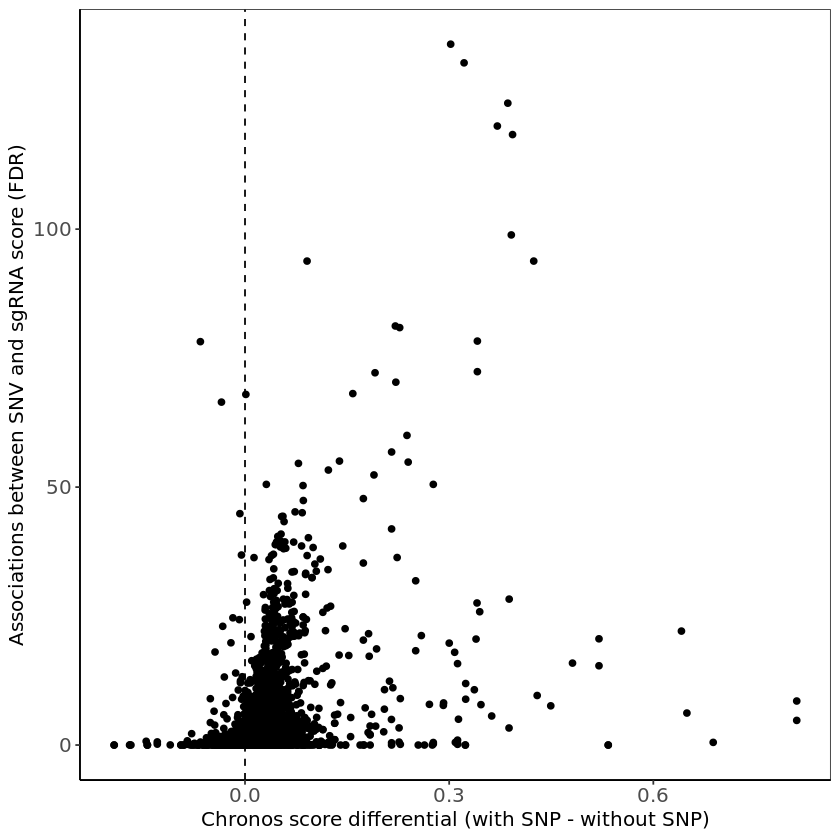

In [49]:
#Plot the plot
final.df.gene.with.differential %>%
ggplot(aes(x = differential, y = -log10(fdr))) +
geom_point() +

geom_vline(xintercept = 0, linetype = 2) +

theme_bw() +

theme(
panel.grid.major = element_blank(),
panel.grid.minor = element_blank(), 
axis.line = element_line(color = "black")
) +

theme(
axis.title.x = element_text(size = 12),
axis.title.y = element_text(size = 12,)
) +

theme(
axis.text=element_text(size = 12),
axis.title=element_text(size = 12)
) +

theme(
legend.title = element_text(size = 12),
legend.text = element_text(size = 12)
) +

ylab("Associations between SNV and sgRNA score (FDR)") +
xlab("Chronos score differential (with SNP - without SNP)")


#Export it to the google bucket
setwd('/home/jupyter/Ancestry/figures')
ggsave("r2c17_guide_significance_volcano.pdf", width = 5, height = 5)
system(glue::glue("
cd /home/jupyter/Ancestry/figures
gsutil cp r2c17_guide_significance_volcano.pdf gs://fc-45c0e148-0b1c-4244-9bfc-feb559bbc514
"))

Do an analysis of the data to address reviewer 2 comment 16:

16) This passage on lines 139-143 was confusing: “Across all sgRNAs in the Cancer Dependency Map, 5.3% have a SNV in their targeting sequence in at least one cell line and 4.3% have such a variant in at least ten cell lines [Figure 2G]. Among the latter, which target a total of 2779 genes, 42% of the guides with a SNV in their targeting sequence show a significant association between the presence of a variant and guide dependency. These guides account for 2.2% of all sgRNAs in DepMap [Figure 2H].” It is unclear what “these guides” refers to, but 42% × 4.3% = 1.8%, not 2.2%, and we are not sure what else might be the intended meaning. Also, the existing Figure 2H does not appear to be relevant to this passage despite being cited here.

In [58]:
#Load in the avana bed file
setwd("/home/jupyter/Ancestry/filtered_output/avana14")
avana.bed <- read.table('Avana14_filtering.bed', sep = "\t", header = F) %>%
rename("chr" = 1, "start" = 2, "end" = 3, "sgrna" = 4) 

#Calculate the total number of guides in the avana library
total.avana.guides = avana.bed %>%
pull(sgrna) %>%
unique() %>%
length()

In [61]:
#Calculate the total number of affected guides
total.affected.guides = final.df.gene.with.differential %>%
pull(sgrna) %>%
unique() %>%
length()

total.affected.genes = final.df.gene.with.differential %>%
pull(gene) %>%
unique() %>%
length

total.guides.with.significant.snp = final.df.gene.with.differential %>%
filter(fdr <= 0.05) %>%
pull(sgrna) %>%
unique() %>%
length()

total.affected.guides
total.affected.genes
total.guides.with.significant.snp

#Calculate the fraction for the paper text
total.guides.with.significant.snp/total.avana.guides

[1] 3742

[1] 2865

[1] 1542

[1] 0.02095194

In [62]:
total.affected.guides/total.avana.guides

[1] 0.05084446